In [78]:
from tensorflow.keras.models import load_model  # For loading a saved model
from matplotlib.ticker import AutoMinorLocator
import mdn  # For Mixture Density Networks
import joblib  # For serialization and deserialization of Python objects
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from sklearn.metrics import r2_score
from Rock.Model.EnsembleMDN import EnsembleMDN
from tortreinador.utils.plot import calculate_GMM
from tortreinador.utils.View import init_weights
from tortreinador.models.MDN import Mixture, NLLLoss
from tortreinador.utils.metrics import r2_score as r2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import math

In [3]:
df_chunk_0 = pd.read_parquet("D:\\Resource\\rockyExoplanetV3\\data_chunk_0.parquet")
df_chunk_1 = pd.read_parquet("D:\\Resource\\rockyExoplanetV3\\data_chunk_1.parquet")

df_all = pd.concat([df_chunk_0, df_chunk_1])

In [4]:
input_parameters = [
    'Mass',
    'Radius',
    'FeMg',
    'SiMg',
    'Mass_Noise',
    'Radius_Noise',
    'FeMg_Noise',
    'SiMg_Noise'
]

output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF',
    'CPS',
    'CTP',
    'k2'
]

In [4]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(scaler_x.fit_transform(df_all[input_parameters[:4]].to_numpy()), scaler_y.fit_transform(df_all[output_parameters].to_numpy()), test_size=0.1, random_state=125)

In [11]:
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20

In [10]:
m_2 = keras.models.load_model('D:\\Resource\\MDN\\rockyExoplanetV3\\model.h5', custom_objects={'MDN': mdn.MDN, 'mdn_loss_func': mdn.get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)})

In [17]:
sample_rand_idx = np.random.randint(0, X_test.shape[0], size=20000)

In [18]:
X_test_sampled = X_test[sample_rand_idx]
y_test_sampled = y_test[sample_rand_idx]

In [19]:
mse_function = mdn.get_mixture_mse_accuracy(OUTPUT_DIMS, N_MIXES)
c = mdn.get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
sample_function = mdn.get_mixture_sampling_fun(OUTPUT_DIMS, N_MIXES)
pred = m_2.predict(X_test_sampled)
samples = sample_function(pred)
print("r2 score: {}, MSE: {}, NLLLoss: {}".format(r2_score(y_test_sampled, samples),
                                                  np.mean(mse_function(y_test_sampled.astype('float32'), pred)),
                                                  np.mean(c(y_test_sampled.astype('float32'), pred))))

r2 score: 0.9395445156788287, MSE: 0.002544329734519124, NLLLoss: -13.209503173828125


In [20]:
mus = np.apply_along_axis((lambda a: a[:N_MIXES * OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES * OUTPUT_DIMS:2 * N_MIXES * OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)
mus = mus.reshape(mus.shape[0], N_MIXES, int(mus.shape[1] / N_MIXES))
sigs = sigs.reshape(sigs.shape[0], N_MIXES, int(sigs.shape[1] / N_MIXES))

In [21]:
tf_GMM = calculate_GMM(pis, mus, sigs)

In [23]:
tf_test_y_inverse = scaler_y.inverse_transform(y_test_sampled)

In [25]:
tf_col_dis = []
for o in range(len(output_parameters)):
    dis = 0
    for i in range(0, tf_GMM.shape[-1], len(output_parameters)):
        test_y_current = tf_test_y_inverse[int(i / len(output_parameters)), o]
        GMM_cal = tf_GMM[:, o + i].reshape(-1, 1)
        offset = np.sqrt((GMM_cal - test_y_current) ** 2)
        dis += np.mean(offset)
    tf_col_dis.append(dis / len(tf_test_y_inverse))

In [26]:
tf_col_dis

[0.12942624748606513,
 0.31394649432756416,
 0.5872808851584715,
 0.12588102788453473,
 0.49116098137752107,
 531.4397889488772,
 3199.016203612213,
 0.6364761625623442]

In [7]:
t_x = np.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_x.npy")
t_y = np.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_y.npy")
m_y = joblib.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_yscaler_20240630.save")

In [6]:
model = EnsembleMDN(int(len(input_parameters) / 2), len(output_parameters), 10, 256, kernel_size=2)
init_weights(model)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\best_model.pth"))

<All keys matched successfully>

In [9]:
rand_idx = torch.randint(0, t_x.shape[0], size=(20000,))
sampled_test_x = t_x[rand_idx]
sampled_test_y = t_y[rand_idx]
t_x_o, t_x_n = np.array_split(sampled_test_x, 2, axis=1)

In [19]:
model.eval()
pred = model(torch.from_numpy(t_x_o), torch.from_numpy(t_x_n))

In [26]:
mix = Mixture()
criterion = NLLLoss()
mse = nn.MSELoss()
sample = mix(pred[0], pred[1], pred[2]).sample()
print("NLLLoss: {}, MSE: {}, R2: {}".format((criterion(pred[0], pred[1], pred[2], torch.from_numpy(sampled_test_y).to('cuda'))),
                                            mse(torch.from_numpy(sampled_test_y).to('cuda'), sample),
                                            r2(sample, torch.from_numpy(sampled_test_y).to('cuda'))))

NLLLoss: -44.20869823588779, MSE: 0.0012548256948102354, R2: 0.9608586190710933


In [27]:
torch_GMM_PDF = calculate_GMM(torch.exp(pred[0]).detach().cpu().numpy(), pred[1].detach().cpu().numpy(), pred[2].detach().cpu().numpy())

In [28]:
torch_test_y_inverse = scaler_y.inverse_transform(sampled_test_y)

In [32]:
torch_col_dis = []
for o in range(len(output_parameters)):
    dis = 0
    for i in range(0, torch_GMM_PDF.shape[-1], len(output_parameters)):
        test_y_current = torch_test_y_inverse[int(i / len(output_parameters)), o]
        GMM_cal = torch_GMM_PDF[:, o + i].reshape(-1, 1)
        offset = np.sqrt((GMM_cal - test_y_current) ** 2)
        dis += np.mean(offset)
    torch_col_dis.append(dis / len(torch_test_y_inverse))

In [33]:
torch_col_dis

[0.10460889902484155,
 0.317102186614911,
 0.5893799308047999,
 0.09091835632806951,
 0.49229983739943917,
 529.6751894080876,
 3203.117553491791,
 0.6502587398106625]

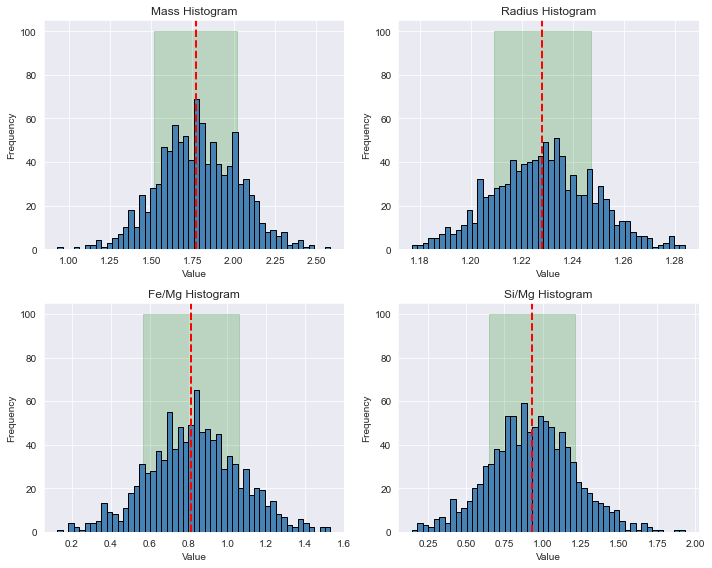

In [97]:
# Set the random seed for reproducibility
np.random.seed(125)

# Define the function to generate samples and plot histogram
def generate_samples_and_plot(mean, err, title, ax):
    """
    Generates Gaussian distributed samples around a mean with a given error,
    and plots a histogram of the samples.
    
    Parameters:
    - mean: The mean value for the Gaussian distribution.
    - err: The standard deviation (error) for the Gaussian distribution.
    - title: The title of the plot.
    - ax: The matplotlib Axes object on which to plot.
    
    Returns:
    - samples: The generated samples.
    """
    samples = np.random.normal(loc=mean, scale=err, size=1000)
    ax.hist(samples, bins=50, color='steelblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)  # Mark the mean value
    ax.fill_between([mean-err, mean+err], [0, 0], [100, 100], alpha=0.2, color='green')  # Highlight the error range
    return samples

# Create subplots for plotting histograms
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Generate and plot samples for various parameters
mass_samples = generate_samples_and_plot(1.77, 0.25, 'Mass Histogram', axs[0, 0])
radius_samples = generate_samples_and_plot(1.228, 0.019, 'Radius Histogram', axs[0, 1])
femg_samples = generate_samples_and_plot(0.813, 0.248, 'Fe/Mg Histogram', axs[1, 0])
simg_samples = generate_samples_and_plot(0.933, 0.281, 'Si/Mg Histogram', axs[1, 1])

# Combine all samples into an input matrix X
X = np.stack([mass_samples, radius_samples, femg_samples, simg_samples], axis=1)

# Adjust the layout of the subplots
plt.tight_layout()

# Display the histograms
plt.show()

In [98]:
mass_samples_ori = np.random.normal(1.77, 0, size=1000)
radius_samples_ori = np.random.normal(1.228, 0, size=1000)
femg_samples_ori = np.random.normal(0.813, 0, size=1000)
simg_samples_ori = np.random.normal(0.933, 0, size=1000)

In [99]:
X_ori = np.stack([mass_samples_ori, radius_samples_ori, femg_samples_ori, simg_samples_ori], axis=1)

In [24]:
def calculate_GMM(p, m, s, y_label):
    """
    Calculate the probability density function of the Gaussian Mixture Model

        Args:
            - param p: pi
            - param m: mean
            - param s: standard deviation
            - param y_label: e.g. np.arange(0, 1, 0.001)

    """
    if len(y_label.shape) == 1:
        y_label = y_label.reshape(-1, 1)
        
    y_label_ = y_label[:, np.newaxis, np.newaxis, :]

    mu_sub_T = np.transpose(m, (0, 2, 1))
    sigma_sub_T = np.transpose(s, (0, 2, 1))

    # shape(1000, 6, 100, 10) 1000 data, 6 type, 100 rows with 10 columns every type
    exponent = np.exp(
        -1 / 2 * np.square(np.transpose((y_label_ - mu_sub_T), (1, 2, 0, 3)) / sigma_sub_T[:, :, np.newaxis, :]))
    factors = 1 / math.sqrt(2 * math.pi) / sigma_sub_T[:, :, np.newaxis, :]
    GMM_PDF = np.sum(p[:, np.newaxis, np.newaxis, :] * factors * exponent, axis=-1)
    GMM_PDF = GMM_PDF.reshape(GMM_PDF.shape[0] * GMM_PDF.shape[1], GMM_PDF.shape[-1]).transpose((-1, 0))
    # f = e.transpose((-1, 0))
    return GMM_PDF

In [70]:
mix = Mixture()
m_y = joblib.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_yscaler_20240630.save")
m_x = joblib.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_xscaler_20240630.save")

In [100]:
X_com = np.concatenate((X, X_ori), axis=1)

In [101]:
X_scaled = m_x.transform(X_com)

E:\anaconda\envs\deeplearning\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [102]:
tensor_x = torch.from_numpy(X_scaled)
x_o, x_n = tensor_x.chunk(2, dim=1)

In [103]:
pred = model(x_o, x_n)

In [50]:
y_l = np.arange(0, 1, 0.001).reshape(-1, 1)

In [104]:
sample = mix(pred[0], pred[1], pred[2]).sample()
sample_inverse = m_y.inverse_transform(sample.cpu().numpy())

In [35]:
mcmc_result = pd.read_csv("D:\\Resource\\rockyExoplanetV3\\Kepler78b_feo.csv")
mcmc_result["MRF"] = 1 - mcmc_result["WRF"] - mcmc_result["CRF"]

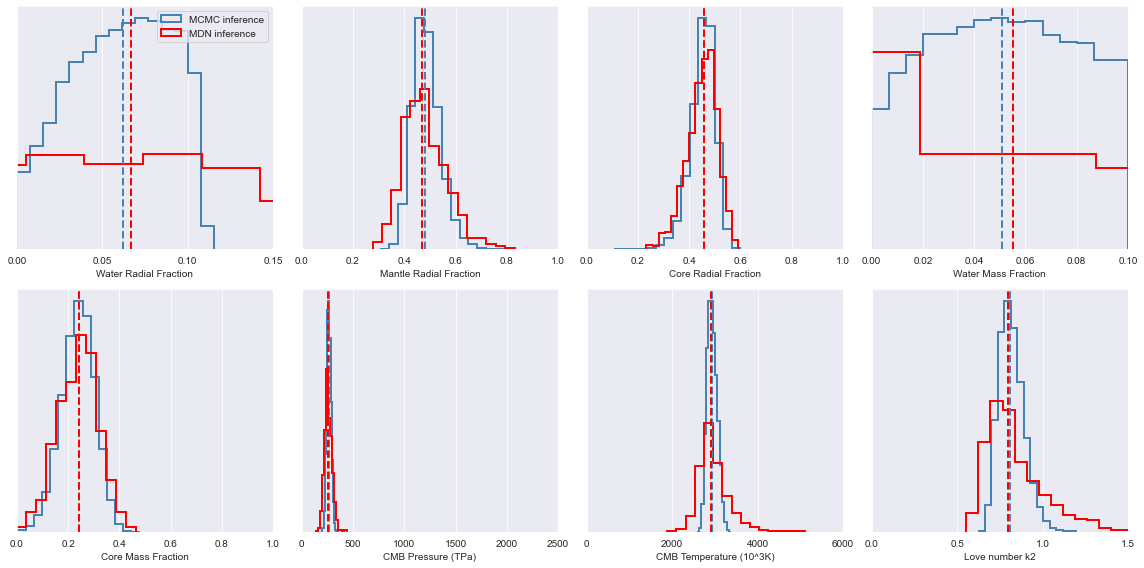

In [105]:
x_labels = ['Water Radial Fraction', 'Mantle Radial Fraction', 'Core Radial Fraction', 
            'Water Mass Fraction', 'Core Mass Fraction', 'CMB Pressure (TPa)', 
            'CMB Temperature (10^3K)', 'Love number k2']
x_max = [0.15, 1, 1, 0.1, 1, 2500, 6000, 1.5]
x_locator = [0.05, 0.2, 0.2, 0.02, 0.2, 500, 2000, 0.5]
colors = ["steelblue"] * len(output_parameters)

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()
for i, param in enumerate(output_parameters):
    ax = axs[i]
    # plot MCMC results
    x = mcmc_result[param]
    ax.hist(x, density=True, bins=15, histtype='step', color='#4682b4', linewidth=2, label='MCMC inference')
    median = np.median(x)
    ax.axvline(median, color='#4682b4', linestyle='--', lw=2)
    
    # plot MDN results
    params_x = sample_inverse[:,i]
    counts, bins, _ = ax.hist(params_x, density=True, bins=15, histtype='step', color='red', linewidth=2, label='MDN inference')
    median = np.median(params_x)
    ax.axvline(median, color='r', linestyle='--', lw=2)
    
    # Set x-axis label from the provided list
    ax.set_xlabel(x_labels[i])

    ax.set_xlim(0, x_max[i])
    ax.set_yticks([])
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_locator[i]))
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    # Add legend to the first subplot
    if i == 0:
        ax.legend()

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()